<a href="https://colab.research.google.com/github/dmw1998/Case_Study_Log/blob/main/Uncertainty_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# !pip install casadi

In [25]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

**[From Chenhong]** The simplified optimal control problem is as follows:
\begin{equation*}
    \operatorname{min}\,J(u):=\int_{0}^{t_{f}}(h_{R}-h(t))^{6}\,dt
\end{equation*}
such that
\begin{align*}
    \dot{x}&= V \operatorname{cos}\gamma + W_{x},\\
    \dot{h}&=V\operatorname{sin}\gamma + W_{h},\\
    \dot{V}&=\frac{T}{m}\operatorname{cos}(\alpha+\delta)-\frac{D}{m}-g\operatorname{sin}\gamma-(\dot{W_{x}}\operatorname{cos}\gamma+\dot{W_{h}}\operatorname{sin}\gamma),\\
    \dot{\gamma}&=\frac{T}{mV}\operatorname{sin}(\alpha+\delta)+\frac{L}{mV}-\frac{g}{V}\operatorname{cos}\gamma+\frac{1}{V}(\dot{W_{x}}\operatorname{sin}\gamma-\dot{W_{h}}\operatorname{cos}\gamma),\\
    \dot{\alpha}&= u,\\
    |u|&\leq u_{\operatorname{max}},\\
    |\alpha|&\leq \alpha_{\operatorname{max}},
\end{align*}
where
\begin{align*}
    T(V)&=A_{0}+A_{1}V+A_{2}V^{2},\\
    D(V)&= 0.1\rho SV^{2}, \\
    L(V,\alpha)& = \frac{S\rho}{2}(C_{0}+C_{1}\alpha)V^{2},
\end{align*}
with boundary conditions
\begin{align*}
    x(0) &= 0 \operatorname{ft},\\
    h(0) &= 600 \operatorname{ft},\\
    V(0) &= 239.7 \operatorname{ft}\operatorname{sec}^{-1},\\
    \gamma(0) &= -0.3925\times 10^{-1} \operatorname{rad},\\
    \alpha(0) &= 0.1283 \operatorname{rad},\\
    \gamma(t_{f}) & = -0.5236\times 10^{-1} \operatorname{rad}.
\end{align*}
The wind model
\begin{equation*}
    W_{x}(x)=\begin{cases}
        -k, \qquad \qquad \qquad x\leq a\\
        -k+2k\frac{(x-a)}{(b-a)},\quad a\leq x\leq b\\
        k,\qquad\qquad\qquad\qquad x\geq b
    \end{cases}
\end{equation*}

\begin{equation*}
    W_{h}(x,h)=\begin{cases}
        -k\frac{h}{h_{\ast}}\frac{(x-a)}{c-a}, \quad  a\leq x\leq c\\
        -k\frac{h}{h_{\ast}}\frac{(b-x)}{b-c},\quad c\leq x\leq b\\
        0,\qquad\qquad\qquad\qquad ow
    \end{cases}
\end{equation*}
where $k$ is a dimensionless parameter characterizing the intensity of wind shear. It typically takes value $50$.

In [31]:
def solve_ocp(k_value):
    tf = 40
    N = 40
    dt = tf / N

    # Constants
    hR = 1000
    m = 4662
    g = 32.172
    A0 = 0.4456e5
    A1 = -0.2398e2
    A2 = 0.1442e-1
    delta = 0.03491
    rho = 0.2203e-2
    S = 0.1560e4
    C0 = 0.7125
    C1 = 6.0877
    umax = 0.05236
    alphamax = 0.3
    a, b, c = 200, 4500, 2000
    h_star = 1000
    eps = 1e-6

    opti = ca.Opti()
    x = opti.variable(N+1)
    h = opti.variable(N+1)
    V = opti.variable(N+1)
    gamma = opti.variable(N+1)
    alpha = opti.variable(N+1)
    u = opti.variable(N)

    # Define symbolic vars for wind gradient
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")

    def wind_x(x_):
        return ca.if_else(x_ <= a, -k_value,
               ca.if_else(x_ <= b, -k_value + 2 * k_value * (x_ - a) / (b - a + eps), k_value))

    def wind_h(x_, h_):
        return ca.if_else(x_ < a, 0.0,
               ca.if_else(x_ <= c, -k_value * h_ / h_star * (x_ - a) / (c - a + eps),
                 ca.if_else(x_ <= b, -k_value * h_ / h_star * (b - x_) / (b - c + eps), 0.0)))

    # Define symbolic expressions
    Wx_expr = wind_x(x_sym)
    Wh_expr = wind_h(x_sym, h_sym)

    # Compute symbolic gradients
    dWx_dx_fun = ca.Function("dWx_dx_fun", [x_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx_fun", [x_sym, h_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh_fun", [x_sym, h_sym], [ca.gradient(Wh_expr, h_sym)])


    # Dynamics
    def aircraft_ode(X, u_):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)
        T = A0 + A1 * V_ + A2 * V_**2
        D = 0.1 * rho * S * V_**2
        L = 0.5 * rho * S * (C0 + C1 * alpha_) * V_**2
        Wx = wind_x(x_)
        Wh = wind_h(x_, h_)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        # Evaluate wind derivatives at current state
        dWx_dx_val = dWx_dx_fun(x_)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_)[0]

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = (
            T / m * ca.cos(alpha_ + delta)
            - D / m
            - g * ca.sin(gamma_)
            - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        )

        gamma_dot = (
            T / (m * V_safe) * ca.sin(alpha_ + delta)
            + L / (m * V_safe)
            - g / V_safe * ca.cos(gamma_)
            + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        )

        alpha_dot = u_
        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    # Create integrator
    X_sym = ca.MX.sym("X", 5)
    u_sym = ca.MX.sym("u")
    ode_rhs = aircraft_ode(X_sym, u_sym)
    ode = {"x": X_sym, "p": u_sym, "ode": ode_rhs}
    # intg = ca.integrator("intg", "cvodes", ode, {"t0": 0, "tf": dt})
    intg = ca.integrator("intg", "rk", ode, {"tf": dt})

    # Initial + terminal conditions
    opti.subject_to(x[0] == 0)
    opti.subject_to(h[0] == 600)
    opti.subject_to(V[0] == 239.7)
    opti.subject_to(gamma[0] == -0.03925)
    opti.subject_to(alpha[0] == 0.1283)
    opti.subject_to(gamma[-1] == -0.05236)

    # Collocation constraints
    for i in range(N):
        Xk = ca.vertcat(x[i], h[i], V[i], gamma[i], alpha[i])
        Uk = u[i]
        Xk_end = intg(x0=Xk, p=Uk)["xf"]
        X_next = ca.vertcat(x[i+1], h[i+1], V[i+1], gamma[i+1], alpha[i+1])
        opti.subject_to(X_next == Xk_end)
        opti.subject_to(ca.fabs(u[i]) <= umax)
        opti.subject_to(ca.fabs(alpha[i]) <= alphamax)

    # Objective
    hR = 1000
    J = dt * ca.sumsqr(ca.vertcat(*[(hR - h[i])**3 for i in range(N+1)]))
    opti.minimize(J)

    # Initial guess
    opti.set_initial(x, ca.linspace(0, 10000, N+1))
    opti.set_initial(h, ca.linspace(600, 300, N+1))
    opti.set_initial(V, 239.7)
    opti.set_initial(gamma, -0.03925)
    opti.set_initial(alpha, 0.1283)
    opti.set_initial(u, 0)

    # Solver
    opti.solver('ipopt', {
        'ipopt': {
            'max_iter': 1000,
            'tol': 1e-6,
            'print_level': 0,
            'linear_solver': 'mumps',
            'hessian_approximation': 'limited-memory'
        }
    })

    sol = opti.solve()
    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "J": sol.value(J),
    }


In [32]:
result = solve_ocp(50)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  21.11ms ( 24.84us)  21.08ms ( 24.80us)       850
       nlp_g  |  26.38 s ( 31.04ms)  26.50 s ( 31.18ms)       850
  nlp_grad_f  |  25.54ms ( 32.29us)  25.46ms ( 32.18us)       791
   nlp_jac_g  | 185.01 s (233.90ms) 186.19 s (235.38ms)       791
       total  | 219.73 s (219.73 s) 221.05 s (221.05 s)         1


In [33]:
def plot_trajectory_with_wind(result, k_value):
    # 1. Get results
    x_traj = result["x"]
    h_traj = result["h"]

    # 2. Grids
    x_grid = np.linspace(0, 9000, 100)
    h_grid = np.linspace(0, 1100, 60)
    X, H = np.meshgrid(x_grid, h_grid)

    # 3. Wind Model
    a, b, c = 200, 4500, 2000
    h_star = 1000
    eps = 1e-6

    def Wx(x):
        return np.where(
            x <= a, -k_value,
            np.where(x <= b, -k_value + 2 * k_value * (x - a) / (b - a + eps), k_value)
        )

    def Wh(x, h):
        out = np.zeros_like(x)
        mask1 = (x >= a) & (x <= c)
        mask2 = (x >= c) & (x <= b)
        out[mask1] = -k_value * h[mask1] / h_star * (x[mask1] - a) / (c - a + eps)
        out[mask2] = -k_value * h[mask2] / h_star * (b - x[mask2]) / (b - c + eps)
        return out

    # 4. Compute wind field
    Wx_vals = Wx(X)
    Wh_vals = Wh(X, H)

    # 5. Plot
    plt.figure(figsize=(10, 6))
    plt.streamplot(x_grid, h_grid, Wx_vals, Wh_vals, density=1.2, linewidth=0.7, color="lightblue")
    plt.plot(x_traj, h_traj, 'k', linewidth=2, label="Trajectory")
    plt.xlabel("horizontal distance [ft]")
    plt.ylabel("altitude [ft]")
    plt.title(f"Trajectory with wind field (k = {k_value})")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.gca().set_aspect('auto')
    plt.show()

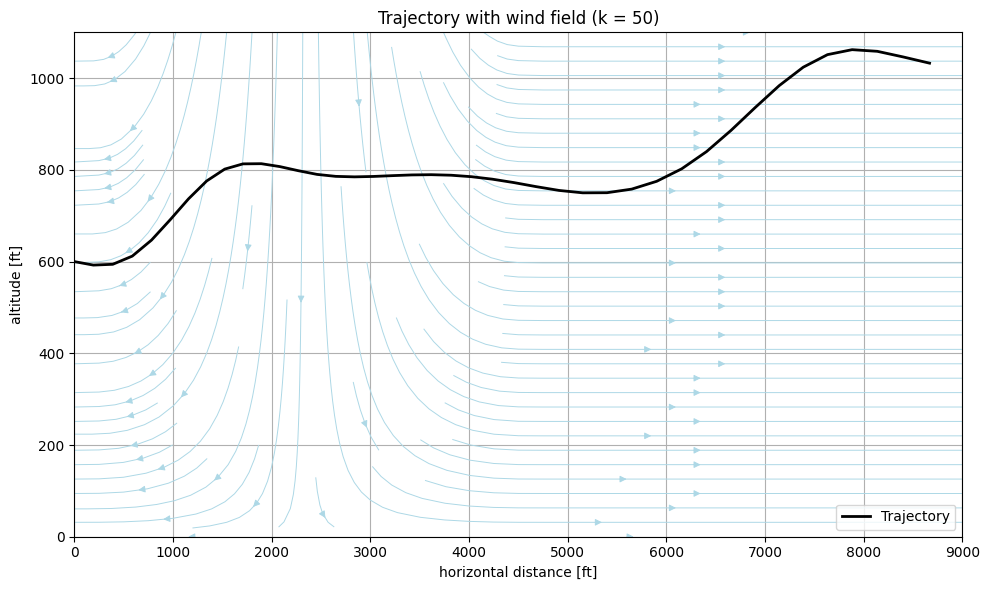

In [34]:
plot_trajectory_with_wind(result, k_value=50)